In [160]:
#pipeline models
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD

# pre processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.svm import SVC


#scoring metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, f1_score, plot_roc_curve, plot_confusion_matrix


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pd.set_option("display.max_rows", 9999)
pd.set_option("display.max_columns", 9999)
plt.style.use('seaborn')


In [133]:
tweets = pd.read_csv('../datasets/final_tweets.csv')

#### Baseline score : 50%

In [135]:
tweets.columns

Index(['source', 'text', 'created_at', 'retweet_count', 'favorite_count',
       'clean_text', 'year', 'month', 'day', 'year_month', 'day_of_week',
       'hour_of_day', 'handle', 'word_count', 'trade_date', 'prev_change',
       'change_pc', 'target', 'char_count', 'lemmas_token', 'lemmas_text',
       'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5',
       'dominant_topic', 'compound_score', 'neg_score', 'neu_score',
       'pos_score'],
      dtype='object')

In [136]:
features = ['trade_date', 'text', 'lemmas_text', 'target']

X = tweets[features]
y = tweets['target']

In [137]:
X.shape, y.shape

((957, 4), (957,))

In [138]:
#split to training and testing set(final test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [139]:
# Obtain the text data
get_text_data = FunctionTransformer(lambda x: x['lemmas_text'], validate=False)


In [140]:
#Create an empty dictionary to store the metric score when function is called
metrics = {}
# dictionary to hold the models for each runs
models = {}
# Dataframe to hold the predictions for validataion set
preds_df = X_test.copy()

In [173]:
def score_metrics(model_name, pipe, params,  X_train, y_train, X_test, y_test, scoring,  models, preds_df):
    
    """ 
    Function to fit and collect model metrics
  
    Parameters: 
        tag (str): name for this pipeline
        pipe (pipeline): pipeline to be executed
		param (dict): dictionary of parameters to be used
        X_train (Series): Series holding the train feature
        X_test (Series): Series holding the test feature
        y_train (Series): Series holding the train target
        y_test (Series): Series holding the test target
        scoring (str): scoring metric for the search
        
    """

#     gs = GridSearchCV(pipe, param_grid=params, cv=5,
#                             scoring=scoring)
    
    gs = RandomizedSearchCV(pipe, param_distributions=params, cv=5, n_iter=20,
                            scoring=scoring)    
    gs.fit(X_train, y_train)
    bm = gs.best_estimator_
    models[model_name] = gs
    y_pred = bm.predict(X_test)
    preds_df[model_name]=y_pred
    print(f'{model_name}->Best params: {gs.best_params_}')
    
    metric = {}
    metric['01 Train score'] = f'{bm.score(X_train, y_train):,.4f}'
    metric['02 Test score'] = f'{bm.score(X_test, y_test):,.4f}'
    metric['03 Score diff'] = float(metric['01 Train score'])-float(metric['02 Test score'])

    # calculate Specificity and Sensitivity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    metric['04 Precision'] = f'{(tp /(tp + fp)):.4f}'
    metric['05 Specificity'] = f'{(tn / (tn + fp)):.4f}'
    metric['06 Sensitivity'] = f'{(tp / (tp + fn)):.4f}'
    metric['07 F1 Score'] = f'{f1_score(y_test, y_pred):.4f}'
    metric['08 True Negatives'] = tn
    metric['09 False Positives'] = fp
    metric['10 False Negatives'] = fn
    metric['11 True Positives'] = tp
    metric['12 Train ROC Score'] = f'{roc_auc_score(y_train, bm.predict_proba(X_train)[:,1]):,.4f}'
    metric['13 Test ROC Score'] = f'{roc_auc_score(y_test, bm.predict_proba(X_test)[:,1]):,.4f}'

    # plot roc and confusion matrix
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    plot_roc_curve(bm, X_test, y_test, name=model_name, ax=ax[0]);
    # Plot baseline. (Perfect overlap between the two populations.)
    ax[0].plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200),
             label='baseline', linestyle='--')
    plot_confusion_matrix(bm, X_test, y_test, ax=ax[1], cmap='RdPu');
    ax[0].set_title(f'ROC for {model_name}');
    ax[1].set_title(f'Confusion Matrix for {model_name}');
    
    return metric

### Logistic Regression

In [174]:
logreg_pipe = Pipeline([
    ('selector', get_text_data),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2), stop_words='english')),
    ('sampling', SMOTE(random_state=42)),
    ('clf', LogisticRegression(solver='liblinear'))

])

lr_params = {

    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.1, 0.01, 0.001]

}

/Users/jeremytan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


log_reg->Best params: {'clf__penalty': 'l2', 'clf__C': 0.1}
CPU times: user 2.85 s, sys: 50.2 ms, total: 2.9 s
Wall time: 1.82 s


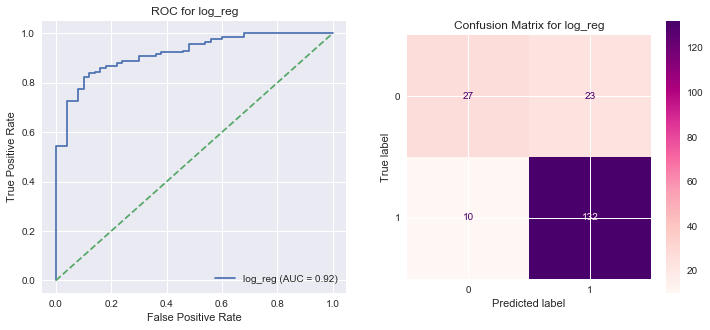

In [175]:
%%time
metrics['log_reg'] = score_metrics('log_reg', logreg_pipe, 
                                   lr_params, X_train, 
                                   y_train, X_test, 
                                   y_test, 'roc_auc', models, preds_df)

In [176]:
pd.DataFrame(metrics)

,log_reg,nb,rf,xgb,svc
01 Train score,0.9830,0.9490,0.9948,0.9817,1.0000
02 Test score,0.8281,0.8490,0.8490,0.8438,0.7500
03 Score diff,0.1549,0.1,0.1458,0.1379,0.25
04 Precision,0.8516,0.8742,0.8304,0.8333,0.7474
05 Specificity,0.5400,0.6200,0.4200,0.4400,0.0400
06 Sensitivity,0.9296,0.9296,1.0000,0.9859,1.0000
07 F1 Score,0.8889,0.9010,0.9073,0.9032,0.8554
08 True Negatives,27,31,21,22,2
09 False Positives,23,19,29,28,48
10 False Negatives,10,10,0,2,0


### MultinomialNB

In [211]:
nb_pipe = Pipeline([
    ('selector', get_text_data),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2),
                                  stop_words='english')),
    ('sampling', SMOTE(random_state=42)),
    ('feature_selection', SelectKBest()),
    ('scale', MaxAbsScaler()),
    ('clf', MultinomialNB())

])

nb_params = {

    'feature_selection__k': [200, 400, 600, 800],
    'feature_selection__score_func': [chi2, f_classif],
 
}

/Users/jeremytan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


nb->Best params: {'feature_selection__score_func': <function chi2 at 0x7fadf16780e0>, 'feature_selection__k': 400}
CPU times: user 2.53 s, sys: 56.5 ms, total: 2.59 s
Wall time: 2.65 s


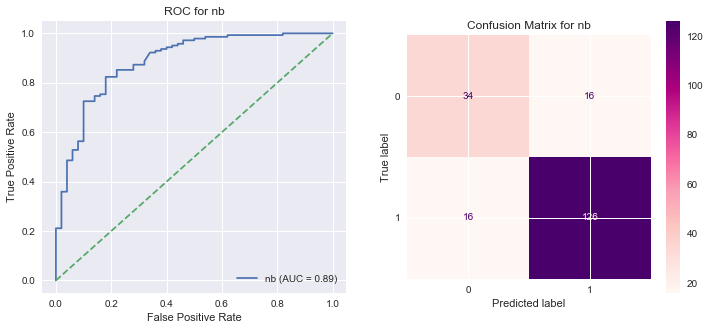

In [212]:
%%time
metrics['nb'] = score_metrics('nb', nb_pipe, nb_params, X_train, y_train, 
                              X_test, y_test,'roc_auc', models, preds_df)

In [213]:
pd.DataFrame(metrics)

,log_reg,nb,rf,xgb,svc
01 Train score,0.9830,0.9255,0.9908,0.9765,1.0000
02 Test score,0.8281,0.8333,0.8281,0.8490,0.8542
03 Score diff,0.1549,0.0922,0.1627,0.1275,0.1458
04 Precision,0.8516,0.8873,0.8114,0.8343,0.8519
05 Specificity,0.5400,0.6800,0.3400,0.4400,0.5200
06 Sensitivity,0.9296,0.8873,1.0000,0.9930,0.9718
07 F1 Score,0.8889,0.8873,0.8959,0.9068,0.9079
08 True Negatives,27,34,17,22,26
09 False Positives,23,16,33,28,24
10 False Negatives,10,16,0,1,4


### RandomForest

In [180]:
rf_pipe = Pipeline([

    ('selector', get_text_data),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2),
                                  stop_words='english')),     
    ('sampling', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier())

])

rf_params = {

    
    'clf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'clf__max_features': ['auto', 'sqrt'],
    'clf__min_samples_split': [2, 5, 10],
    'clf__n_estimators': [200, 400, 600, 800, 1000],
    'clf__bootstrap': [True, False],
    'clf__min_samples_leaf': [1, 2, 4],
    
}

rf->Best params: {'clf__n_estimators': 800, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 50, 'clf__bootstrap': False}
CPU times: user 2min 21s, sys: 1.6 s, total: 2min 22s
Wall time: 2min 24s


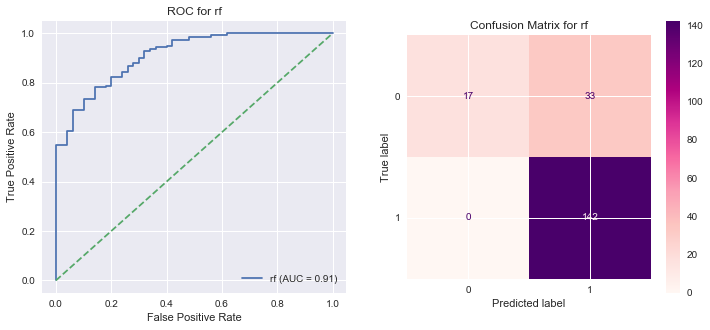

In [181]:
%%time
metrics['rf'] = score_metrics('rf', rf_pipe, rf_params, X_train, y_train, 
                              X_test, y_test,'roc_auc', models, preds_df)

In [182]:
pd.DataFrame(metrics)

,log_reg,nb,rf,xgb,svc
01 Train score,0.9830,0.9490,0.9908,0.9817,1.0000
02 Test score,0.8281,0.8490,0.8281,0.8438,0.7500
03 Score diff,0.1549,0.1,0.1627,0.1379,0.25
04 Precision,0.8516,0.8742,0.8114,0.8333,0.7474
05 Specificity,0.5400,0.6200,0.3400,0.4400,0.0400
06 Sensitivity,0.9296,0.9296,1.0000,0.9859,1.0000
07 F1 Score,0.8889,0.9010,0.8959,0.9032,0.8554
08 True Negatives,27,31,17,22,2
09 False Positives,23,19,33,28,48
10 False Negatives,10,10,0,2,0


### XGBoost

In [189]:
xgb_pipe = Pipeline([

    ('selector', get_text_data),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2),
                                  stop_words='english')),   
    ('sampling', SMOTE(random_state=42)),
    ('clf', XGBClassifier())

])

xgb_params = {

    'clf__max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
    'clf__learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
    'clf__"min_child_weight': [ 1, 3, 5, 7 ],
    'clf__gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    'clf__colsample_bytree': [ 0.3, 0.4, 0.5 , 0.7 ]
    

}

xgb->Best params: {'clf__max_depth': 10, 'clf__learning_rate': 0.1, 'clf__gamma': 0.4, 'clf__colsample_bytree': 0.3, 'clf__"min_child_weight': 5}
CPU times: user 5min 17s, sys: 1.27 s, total: 5min 18s
Wall time: 5min 22s


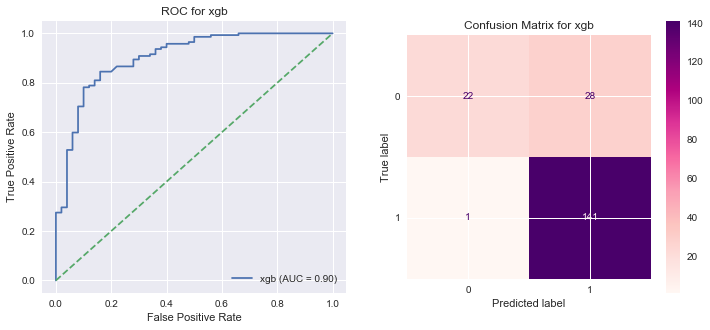

In [190]:
%%time
metrics['xgb'] = score_metrics('xgb', xgb_pipe, xgb_params, X_train, y_train, 
                              X_test, y_test,'roc_auc', models, preds_df)

In [191]:
pd.DataFrame(metrics)

,log_reg,nb,rf,xgb,svc
01 Train score,0.9830,0.9490,0.9908,0.9765,1.0000
02 Test score,0.8281,0.8490,0.8281,0.8490,0.8646
03 Score diff,0.1549,0.1,0.1627,0.1275,0.1354
04 Precision,0.8516,0.8742,0.8114,0.8343,0.8580
05 Specificity,0.5400,0.6200,0.3400,0.4400,0.5400
06 Sensitivity,0.9296,0.9296,1.0000,0.9930,0.9789
07 F1 Score,0.8889,0.9010,0.8959,0.9068,0.9145
08 True Negatives,27,31,17,22,27
09 False Positives,23,19,33,28,23
10 False Negatives,10,10,0,1,3


### SVC

In [192]:
svc_pipe = Pipeline([

    ('selector', get_text_data),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2),
                                  stop_words='english')), 
    ('sampling', SMOTE(random_state=42)),
    ('scale', MaxAbsScaler()),
    ('clf', SVC(probability=True)),

])

svc_params = {
    
    'clf__kernel': ['rbf', 'poly'],
    'clf__gamma': [0.1, 1, 10, 100],
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__degree': [0, 1, 2, 3, 4, 5, 6]
}

svc->Best params: {'clf__kernel': 'poly', 'clf__gamma': 1, 'clf__degree': 1, 'clf__C': 0.1}
CPU times: user 1min 45s, sys: 421 ms, total: 1min 45s
Wall time: 1min 46s


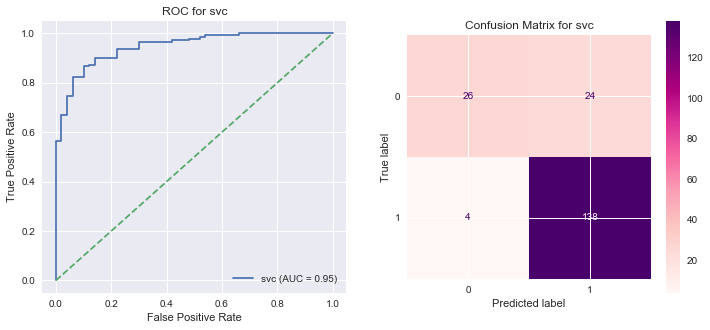

In [193]:
%%time
metrics['svc'] = score_metrics('svc', svc_pipe, svc_params, X_train, y_train, 
                              X_test, y_test,'roc_auc', models, preds_df)

In [194]:
pd.DataFrame(metrics)

,log_reg,nb,rf,xgb,svc
01 Train score,0.9830,0.9490,0.9908,0.9765,1.0000
02 Test score,0.8281,0.8490,0.8281,0.8490,0.8542
03 Score diff,0.1549,0.1,0.1627,0.1275,0.1458
04 Precision,0.8516,0.8742,0.8114,0.8343,0.8519
05 Specificity,0.5400,0.6200,0.3400,0.4400,0.5200
06 Sensitivity,0.9296,0.9296,1.0000,0.9930,0.9718
07 F1 Score,0.8889,0.9010,0.8959,0.9068,0.9079
08 True Negatives,27,31,17,22,26
09 False Positives,23,19,33,28,24
10 False Negatives,10,10,0,1,4


## Model Selection : MultinomialNB

After comparing the 5 models, MultinomialNB has the best overall score. All models seems to be slightly overfitted. The test score for all 5 models hover around 0.8 and MNB has the lowest false positives which is important when we deploy this model for trading. Trading on false positives might result financial loss. Hence we rather to missed good trade than to trade on false signals. 

In [222]:
def get_feature_impt(model):
    coef = models[model].best_estimator_['clf'].coef_[0]
    features_name = models[model].best_estimator_['vectorizer'].get_feature_names()
    features_select = models[model].best_estimator_['feature_selection'].get_support()
    
    impt_features = []

    for bool, feature in zip(features_select, features_name):
        if bool:
            impt_features.append(feature)
        
    return pd.DataFrame(zip(impt_features,feature_impt), columns=['feature', 'importance'])

In [ ]:
features = get_feature_impt('nb')

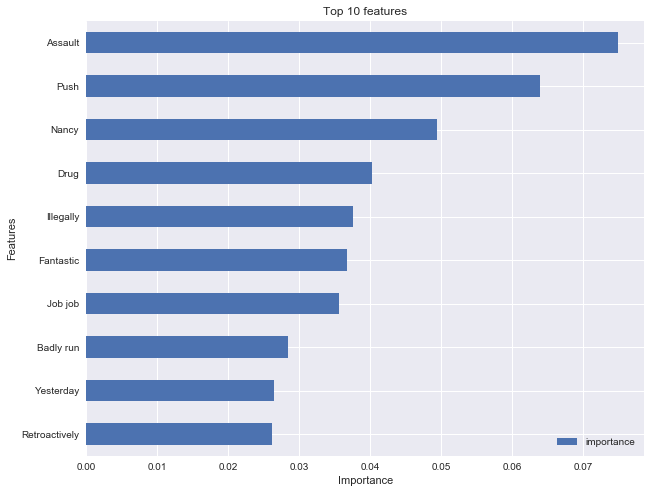

In [433]:
fig, ax = plt.subplots(figsize=(10,8))
mask = features.sort_values(by='importance', ascending=False).head(10)
mask.plot(kind='barh' ,ax=ax)
ax.set_yticklabels([name.capitalize() for name in mask['feature']]);
ax.set_ylabel('Features')
ax.set_xlabel('Importance')
ax.set_title('Top 10 features')
fig.gca().invert_yaxis()

The above chart shows the top 10 features with highest coefficient. 

## Recommendation: Backtesting 

Based on the predictions, i have created a simple trading strategy to backtest on the S&P500. We will be focusing only on buy signals for this strategy. 1 indicating buy signal and 0 to do nothing. The strategy is to buy at tommorrow's open and sell at tomorrow’s close if the tweet is predicted 1. 

In [415]:
#load the S&P 500 data 
market = pd.read_csv('../datasets/cleaned_market.csv')
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         937 non-null    object 
 1   open         937 non-null    float64
 2   high         937 non-null    float64
 3   low          937 non-null    float64
 4   close        937 non-null    float64
 5   volume       937 non-null    int64  
 6   change_pc    937 non-null    float64
 7   target       937 non-null    int64  
 8   prev_change  937 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 66.0+ KB


In [416]:
#set the datetime format
market.date = pd.to_datetime(market.date)
market.set_index('date', inplace=True)

In [417]:
#drop unneccessary columns
market.drop(columns=['prev_change'], inplace=True)

In [418]:
#create a copy of the predictions that i have created during the modeling
preds = preds_df.copy()

In [419]:
#set datetime format
preds.trade_date = pd.to_datetime(preds.trade_date)

In [420]:
#sort the prediction by dates
preds = preds.sort_values(by='trade_date')

In [421]:
#filter only NB predictions together with the date and text
preds = preds[['trade_date', 'text', 'nb']]
preds.rename(columns={'trade_date': 'date'}, inplace=True)

In [422]:
#merge the prediction to the market data
preds = pd.merge(market, preds, how='outer', on='date')

In [423]:
#set datetime as index
preds.set_index('date', inplace=True)

In [424]:
#check for nulls
preds.isnull().sum()

open          62
high          62
low           62
close         62
volume        62
change_pc     62
target        62
text         817
nb           817
dtype: int64

In [425]:
#the duplicates here suggest that there are multiple buy signals on the same day 
#therefore we drop these duplicates
preds = preds.drop_duplicates(subset=[col for col in preds.columns if col != 'text'])

In [426]:
preds.isnull().sum()

open           2
high           2
low            2
close          2
volume         2
change_pc      2
target         2
text         817
nb           817
dtype: int64

In [427]:
#fill null with 0 since we will only be focusing on buy signals
preds['nb'].fillna(0, inplace=True)

In [428]:
preds = preds[:-2].copy()

In [429]:
#create new columns for cumulative returns for NB model and S&P 500 
preds['nb_returns'] = (preds['nb'] * preds['change_pc']) 
preds['cum_returns'] = (preds['change_pc'] + 1).cumprod() - 1
preds['nb_cum_returns'] = (preds['nb_returns'] + 1).cumprod() - 1

In [373]:
#a list of all buy signals and it's cumulative returns
long_trades = preds.loc[preds['nb'] == 1, 'cum_returns']

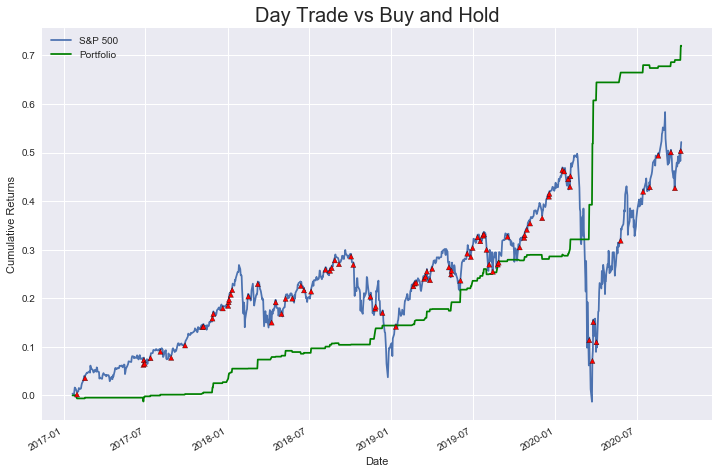

In [432]:
#plot the backtesting strategy 
fig, ax = plt.subplots(figsize=(12,8))
preds['cum_returns'].plot(label='S&P 500')
preds['nb_cum_returns'].plot(label='Portfolio', c='green')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')

for k,v in long_trades.iteritems():
    ax.annotate(' ', xy=(k, v), xycoords='data',
            arrowprops=dict(facecolor='red', mutation_aspect=1, mutation_scale=0.7),)

ax.set_title("Day Trade vs Buy and Hold", fontsize=20)
ax.legend()

# Conclusion

The trading strategy based on our prediction model returned a 72% vs a buy and hold strategy of 52% over the same period of time. We also observed that the returns of the strategy was behind until around March 2020 when there's a heavy selloff in the market. Even thou returns was lower but this strategy greatly reduce the volatility in the portfolio. Having a buy and hold strategy means that you expose yourself to the 100% volatility in the market. You can clearly see that during selloff in March 2020, not only our strategy was not impacted by the selloff but on the other hand we made around 20%.

However we also need to be aware that there's a possibility that we are just lucky. Majority of the buy signals were generated in market uptrends, in a trending bull market it will generate more buy signals and President Trump tweets might just coincide with other market mover such as non farm payroll events, FED economic data release, or other factors. For this project we will state that his tweets does have a positive relationship with market returns. 

In conclusion, through topic modelling with LDA and VADER sentiment analysis we were able to filter out the noise of President Trump tweets and isolate his sentiment towards trade and economy related issues. Using a MultinomialNB model to classify President Trump tweets that have positive impact on the market and use those predictions over a backtest was profitable and outperform the buy and hold strategy.